# 프로젝트 : 폐렴 진단기 성능개선

**Step 1. 실험환경 Set-up**

거의 바꿔볼 수 있을 게 없을 것 같지만, Batch size, Epoch 등을 변경해볼 수 있을 것입니다.

In [1]:
# 라이브러리 임포트
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
# 필요한 변수들을 생성
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 30

print(ROOT_PATH)

/aiffel/aiffel


**Step 2. 데이터 준비하기**

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [4]:
# train과 val에 있는 데이터를 모은 다음에 train : val를 80:20으로 분할해보자
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8) # # test_size를 수정하면 개수는 달라질 수 있습니다.
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames)) # 4185
print(len(val_filenames)) # 1047

4185
1047


In [5]:
# train 데이터 안에 정상 이미지 수와 폐렴 이미지 수를 한번 보겠습니다.
# 정상 이미지와 폐렴 이미지를 구분해야 하는데 다행히도 파일 경로에 힌트가 있네요
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1158_virus_1941.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1087
Pneumonia images count in training set: 3098


In [7]:
# tf.data 인스턴스를 만들어 보자 
# tf.data는 tensorflow에서 학습시킬 때, mini-batch로 작업할 수 있도록 해 준다.
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
# Train 데이터셋, validation 데이터셋 개수 확인을 해보자
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [9]:
# 파일 경로에 'NORMAL'이나 'PNEUMONIA'가 포함되어 있다. 
# 이를 이용해서 라벨 데이터를 만들어 주는 함수를 만들어 보자
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)
# 이미지 데이터는 현실적으로 사이즈가 제각각일 가능성이 높습니다.
# 이미지의 사이즈를 통일 시키고 GPU 메모리를 더욱 효율적으로 사용려면 이미지 사이즈를 줄이자

In [10]:
# decode_img 함수와 process_path 함수를 만들어보자
# process_path 함수에서 decode_img 함수를 이용해서 
# 이미지의 데이터 타입을 float으로 바꾸고 사이즈를 변경한다. 
# get_label을 이용해서 라벨 값을 가져옵니다.
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [11]:
# train 데이터 셋과 validation 데이터 셋을 만들어보자 
# num_parallel_calls 파라미터에 위에서 할당한 AUTOTUNE변수를 이용하면 더 빠르게 처리가능
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
# 이미지가 잘 리사이즈 되었는지, 그리고 라벨이 잘 들어가 있는지 확인
for image, label in train_ds.take(1): # train_ds.take(1)은 하나의 데이터만 가져온다는 의미
    print("Image shape: ", image.numpy().shape)  # Image shape:  (180, 180, 3)
    print("Label: ", label.numpy()) # Label:  False

Image shape:  (180, 180, 3)
Label:  True


In [13]:
# test 데이터셋도 만들고 데이터 개수 확인해보자
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


원본 데이터를 가져와서 전처리 및 배치 구성을 진행합니다. 의료 영상 이미지의 특성상 데이터는 언제나 충분하지 않다고 한다. augmentation 기법을 고려해 볼 수 있지만다 의료 영상인 경우, 일반적인 이미지 처리에서 사용하는 augmentation들이 항상 도움이 된다고 말할 수 없다. 특히 X-RAY 같은 의료 영상의 특성상, 육안으로도 구분하기 어려운 미묘한 차이에 더해진 노이즈 등 부수효과가 오히려 방해를 줄 수도 있다. 그래서 augmentation 도입은 신중해야 합니다.

In [14]:
# 만약 예를 들어 좌우 반전 정도의 augmentation만 도입한다고 한다면 다음과 같이 진행될 것입니다.
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

**Step 3. 데이터 시각화**

데이터를 보기 위해 먼저, train에 있는 batch 중 첫 번째 배치를 추출합니다. 추출된 배치를 image와 label 데이터 셋으로 나눕니다. 이제 show_batch() 함수를 이용해서 결과 사진을 보겠습니다.

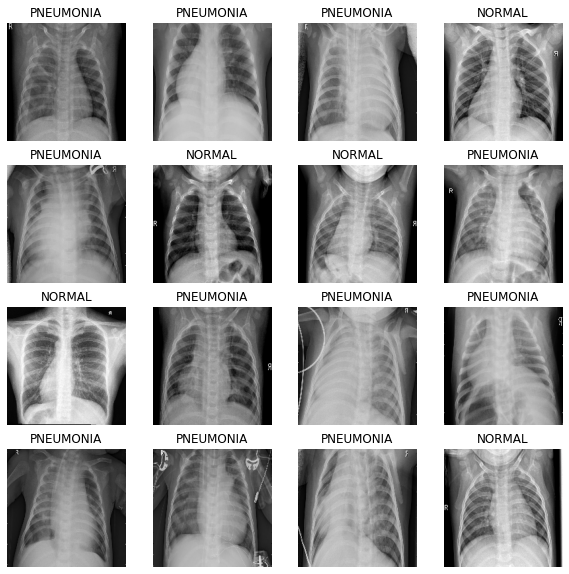

In [15]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

**Step 4. CNN 모델링**

의료 영상 판독을 위해 실습에서 구현했던 model에서 다양한 것들을 바꾸어 가며 실험해볼 수 있습니다. Convolution filter, 채널 개수, activation, 모델 구조 등을 다양하게 바꾸어볼 수 있습니다.

그리고, 우리는 BatchNormalization과 Dropout을 한 모델 안에서 동시에 사용하는 특이한 구성을 실습했습니다.
이것은 일반적으로 잘 사용되는 형태는 아닙니다. 하지만 이미지 사이즈가 크고 데이터가 부족한 의료 영상에서는 실용적으로 간혹 좋은 성능을 보이기도 합니다. 만약 이 구성을 변경해 보면 어떤 효과가 발생하는지도 실험해 봅시다. BatchNormalization을 쓰거나 혹은 쓰지 않거나, Dropout을 쓰거나 혹은 쓰지 않거나 할 수 있습니다. 또, Dropout 비율을 변경해볼 수도 있습니다.

In [16]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [17]:
# Dense Block은 아래와 같이 만듭니다.
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

우리가 만들 CNN 모델은 약간의 수정을 거쳐 만들어진 모델입니다. 전형적인 CNN 모델과는 약간 다른 모델입니다.
어떤 부분이 가장 특이한가요? 눈에 띄셨을지 모르겠지만, 방금 만들어진 모델에는 Batch Normalization과 Dropout이라는 두 가지 regularization 기법이 동시에 사용되고 있습니다. 일반적으로 이런 방법은 잘 사용되지 않거나, 금기시되기도 합니다.
variance shift를 억제하는 Batch Normalization과 이를 유발하는 Dropout을 동시에 사용하는 것이 어울리지 않는다고 밝히고 있습니다.
그러나, 실용적으로는 두 방법을 같이 쓰는 것이 낫다고 보는 견해도 없는 것은 아닙니다. 예외적으로 동시에 사용하는 것이 성능 향상에 도움을 주는 경우가 실제로 있습니다.이번 실습에서는 두 가지를 함께 사용하는 이 모델이 성능 향상에 도움이 될지 여부도 흥미롭게 살펴볼만 한 부분입니다.

In [18]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.7),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.7),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

**Step 5. 데이터 imbalance 처리**

'Normal'과 폐렴에서 'Pneumonia' 중에 'Pneumonia' 데이터가 많이 있었죠? 한 라벨이 너무 많은 경우를 imbalance 하다고 하는데, 데이터를 학습할 때 imbalance한 데이터의 경우 학습 효과가 좋지 않을 수 있습니다.

이런 문제들을 해결하는 방법으로 Weight balancing이라는 테크닉이 사용됩니다. Weight balancing 은 training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법입니다. Keras는 model.fit()을 호출할 때 파라미터로 넘기는 class_weight 에 이러한 클래스별 가중치를 세팅할 수 있도록 지원하고 있습니다. 상세한 내용은 아래 링크를 참고합시다.

[딥러닝에서 클래스 불균형을 다루는 방법](https://3months.tistory.com/414)

아래 코드에서 weight_for_0은 'Normal' 이미지에 사용할 weight를, weight_for_1은 'Pneumonia' 이미지에 사용할 weight를 세팅합니다. 이 weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정됩니다.

In [19]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.93
Weight for PNEUMONIA: 0.68


**Step 6. 모델 훈련**

loss 함수를 변경하기는 어렵겠지만, optimizer나 learning rate 등의 변화를 고려해볼 수 있을 것입니다.

이미지 훈련은 GPU를 사용할 것이기 때문에 먼저 GPU를 선택합니다. 모델은 위에서 만들었던 모델 함수인 build_model()을 model에 선언합니다.

이미지의 라벨이 두 개밖에 없기 때문에 "binary_cross entropy" loss를 사용합니다. optimizer로 'adam'을 사용합니다.성과에 대해서 측정하기 위한 metrics으로 'accuracy', 'precision', 'recall'을 사용합니다.

In [20]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

optimizer를 adam에서 rmsprop으로 바꿔보자

optimizers 임포트 해서 rmsprop으로 저장 되어있던 변수에는 learning_rate가 0.001로 기본값이 지정되어있음 그 learning_rate값을 바꾸기 위해 RMSprop이라는 변수명에 바뀐 값을 지정해서 컴파일할때 optimizer에 넣어서 적용 하면 learning_rate 바꿀수 있음. lr=learning_rate

In [21]:
# 모델을 fit 해보겠습니다. 각 파라미터에 위에서 선언했었던 변수, 
# 데이터 셋을 가져와서 각각에 맞게 넣어줍니다. (모델 학습시 약 20분 이상 소요 됩니다.)
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/30
261/261 [==============================] - 78s 187ms/step - loss: 0.7070 - accuracy: 0.6145 - precision: 0.8376 - recall: 0.5942 - val_loss: 0.5743 - val_accuracy: 0.7500 - val_precision: 0.7500 - val_recall: 1.0000
Epoch 2/30
261/261 [==============================] - 49s 189ms/step - loss: 0.3475 - accuracy: 0.8458 - precision: 0.9629 - recall: 0.8234 - val_loss: 0.7264 - val_accuracy: 0.7490 - val_precision: 0.7490 - val_recall: 1.0000
Epoch 3/30
261/261 [==============================] - 50s 192ms/step - loss: 0.2677 - accuracy: 0.8927 - precision: 0.9711 - recall: 0.8813 - val_loss: 0.3997 - val_accuracy: 0.8058 - val_precision: 0.7957 - val_recall: 0.9974
Epoch 4/30
261/261 [==============================] - 50s 192ms/step - loss: 0.2490 - accuracy: 0.9023 - precision: 0.9692 - recall: 0.8965 - val_loss: 0.2108 - val_accuracy: 0.9106 - val_precision: 0.9699 - val_recall: 0.9090
Epoch 5/30
261/261 [==============================] - 52s 201ms/step - loss: 0.2279 - accura

**Step 7. 결과 확인과 시각화**

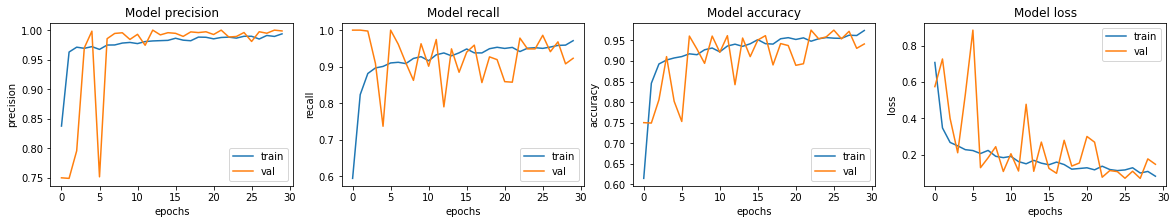

In [22]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [23]:
# 테스트 데이터로 모델 평가를 해보겠습니다.
# 모델 평가를 위해 loss, accuracy, precision, recall 값을 출력해보겠습니다.
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 107ms/step - loss: 0.4482 - accuracy: 0.8590 - precision: 0.8311 - recall: 0.9718
Loss: 0.4482135772705078,
Accuracy: 0.8589743375778198,
Precision: 0.8311403393745422,
Recall: 0.971794843673706


**회고**

처음에 LMS 노드에서 진행했을때 71퍼 나왔다. 

그다음 주피터에서 진행했을때 82퍼 나왔다. 

배치 사이즈 늘리니까 정확도 60퍼까지 떨어졌다. 변경사항: 배치사이즈 32, 나머지 사항은 기존 그대로

배치 사이즈 원래대로 하고 에포크 줄이니까 오르긴 올랐지만 처음에 비하면 약간 떨어진 78퍼로 나왔다. 변경사항: 에포크 20, 나머진 그대로

드롭아웃 올렸더니 83퍼로 올랐다. 변경사항: 에포크 20, 드롭아웃 0.4, 나머진 그대로

BatchNormalization 쓰지 말아 보라고 해서 안써봤는데 77퍼로 떨어짐 변경사항: BatchNormalization사용x, 에포크 20, 드롭아웃 0.4, 나머진 그대로

optimizer를 adam에서 rmsprop으로 바꿔봤는데 78퍼로 큰차이없었다. 변경사항: 에포크 20, 드롭아웃 0.4, 옵티마이저 rmsprop

에포크를 25로 다시 올렸더니 82퍼 까지 올랐다. 변경사항: 에포크 25, 드롭아웃 0,4, 옵티마이저 rmsprop

드롭아웃 0.5로 올렸더니 83퍼 까지 오름. 변경사항: 에포크 25, 드롭아웃 0.5, 옵티마이저 rmsprop

learning_rate 0.001에서 0.5로 올렸는데 48퍼 나옴. 완전 떨어짐 변경사항: 에포크 25, 드롭아웃 0.5, 옵티마이저 resprop, 러닝레이트 0.5

adam에 lr 0.5로 바꾸니까 77퍼 나옴. 변경사항: 에포크 25, 드롭아웃 0.5, 옵티마이저 adam, 러닝레이트 0.5

모든값 기본으로 되돌리고 드롭아웃만 0.5로 바꿔봤는데 73퍼,,, 변경사항: 드롭아웃 0.5

가장 잘 나왔을때로 돌아가보자 드롭아웃 0.4로 해보는데 정확도 68퍼로 떨어짐 왜이런건지 알수 없음

아예 껐다 키고 다시 돌렸는데 75퍼

이미지크기 360으로 늘려봤음 68퍼 나옴

이미지크기 다시 줄이고 에포크 30으로 해봤는데 75퍼 나옴 변경사항 : rmsprop

이미지크기를 90으로 줄이고 에포크 25해 봤는데 75퍼 변경사항: rmsprop

이미지크기를 180으로 되돌리고 에포크는 30으로 늘리고 드롭아웃 0.4로 지정 옵티마이저 adam으로 지정 했더니 81퍼 나옴 오랜만에 80퍼 넘어서 그나마 다행

위랑 동일하고 드롭아웃만 0.6로 수정했는데 83퍼 나옴. 근데 정확도가 높은건 좋은데 드롭아웃만 높히는게 좋은 의미인지는 정확하게 파악하지 못하였음

이것저것 많이 만져 봤지만 85퍼를 충족하지 못하였다. 오히려 아무것도 안함 처음이 거의 젤 잘나왔고 다시 하니까 또 안나오는 이유는 확실하게 알수 없음. 예상하는건 아무래도 초보자가 변수들의 새로운 값을 줘서 건드는거보다 나름 전문가인 노드에 올라온게 아무래도 더 낫지 않은가 싶음.
나만의 생각으론 에포크를 늘리면 정확도가 조금 좋아지는거같고 배치사이즈 늘리면 정확도 떨어지는 경향이 있음 드롭아웃 올리면 정확도 올라가는 경향있는거 같긴하고 러닝레이트를 올리니까 정확도가 크게 떨어졌음 이미지 크기는 늘렸을떄 정확도가 떨어졌지만 크기를 줄였을때는 큰 차이가 없었음

시간이 없어서 마지막으로 한번만 더 해보자 해서 했는데 정확도가 85퍼가 나오긴 하였다. 85퍼가 나오긴 했지만 루브릭에 맞는 85퍼인지는 알수없음. 그래도 일단 뭐라도 한것같으니 다행이라고 생각한다.

**참고자료**

https://keras.io/ko/optimizers/